Changing the Keras backend from TensorFlow to PlaidML

In [2]:
import os

os.environ["RUNFILES_DIR"] = "/Users/shreyasm/opt/anaconda3/share/plaidml"
os.environ["PLAIDML_NATIVE_PATH"] = "/Users/shreyasm/opt/anaconda3/lib/libplaidml.dylib"
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Importing libraries (Remember to import Keras using "import keras" and not "import tensorflow.keras")

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt

Using plaidml.keras.backend backend.


Setting the hyperparameters

In [4]:

batch_size = 128
num_classes = 10
epochs = 15

Set image dimensions

In [5]:
img_rows, img_cols = 28, 28

Loading the datasets

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Viewing the images in the dataset

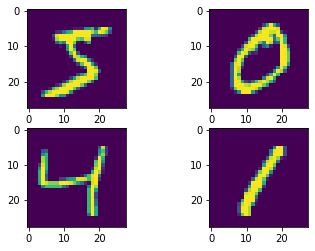

In [7]:
im, arr = plt.subplots(2,2)
arr[0,0].imshow(x_train[0])
arr[0,1].imshow(x_train[1])
arr[1,0].imshow(x_train[2])
arr[1,1].imshow(x_train[3])
plt.show()

Reshaping our data and normalising the pixel values to range between 0 to 255

In [8]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

These are number of images in our training and test dataset

In [9]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Converting the classes to categorical data

In [10]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Calling the model and adding layers to the Neural Network, then configuring it for training (model.compile)

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"


Training the model

In [12]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          shuffle=False)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 39s 657us/step - loss: 0.2386 - acc: 0.9282 - val_loss: 0.0508 - val_acc: 0.9835
Epoch 2/15
60000/60000 [==============================] - 35s 579us/step - loss: 0.0841 - acc: 0.9748 - val_loss: 0.0367 - val_acc: 0.9871
Epoch 3/15
60000/60000 [==============================] - 35s 579us/step - loss: 0.0645 - acc: 0.9801 - val_loss: 0.0311 - val_acc: 0.9895
Epoch 4/15
60000/60000 [==============================] - 35s 578us/step - loss: 0.0495 - acc: 0.9850 - val_loss: 0.0334 - val_acc: 0.9891
Epoch 5/15
60000/60000 [==============================] - 35s 579us/step - loss: 0.0438 - acc: 0.9869 - val_loss: 0.0285 - val_acc: 0.9899
Epoch 6/15
60000/60000 [==============================] - 35s 578us/step - loss: 0.0365 - acc: 0.9886 - val_loss: 0.0300 - val_acc: 0.9900
Epoch 7/15
60000/60000 [==============================] - 35s 578us/step - loss: 0.0323 - acc: 0.9899 - val_loss: 0.

Evaluating the performance of the model using accuracy metrics and plotting the loss over iterations

Test loss: 0.028486798667907716
Test accuracy: 0.9919


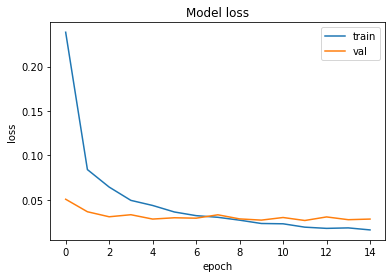

In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()